In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
random_state = 42

In [1]:
def train_test_split(X, Y, N_train):
    np.random.seed(random_state)
    d, N = X.shape
    
    # Define the array of indices
    idx = np.arange(0, N)
    
    # Shuffle the indices
    np.random.shuffle(idx)
    
    # Extract train and test indices
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]
    
    # Extract data
    X_train = X[:, train_idx]
    Y_train = Y[:, train_idx] #its important to not to loose the information of X and Y!! (Y contains the labels of the digit)
    
    X_test = X[:, test_idx]
    Y_test = Y[:, test_idx]
    
    return X_train, Y_train, X_test, Y_test

In [3]:
def test_classes(C1,C2,X,y,C3=False):
    # building the dataset from the chosen classes
    if C3 != False:
        idx = (y[0] == C1) | (y[0] == C2) | (y[0] == C3)
        n_classes = 3
    else:
        idx = (y[0] == C1) | (y[0] == C2) 
        n_classes = 2
    X_sub = X[:, idx]
    y_sub = y[:, idx]    
    N_train = int(0.8 * y_sub.shape[1]) # 80% of the dataset
    X_train, y_train, X_test, y_test = train_test_split(X_sub, y_sub, N_train)
    X1 = X_train[:,y_train[0] == C1]
    X2 = X_train[:,y_train[0] == C2] 
    # training our model
    U1, s1, VT1 = np.linalg.svd(X1, full_matrices=False)
    U2, s2, VT2 = np.linalg.svd(X2, full_matrices=False)
    
    if C3 != False:
        X3 = X_train[:,y_train[0] == C3]
        U3, s3, VT3 = np.linalg.svd(X3, full_matrices=False)
        n_classes = 3
   
    confusion_matrix = np.zeros((n_classes,n_classes))
    N_test = y_test.shape[1]
    size = N_test
    correct_classification = 0

    for index in range(0,N_test):
        y_true = X_test[:, index]
        y_1 = U1 @ (U1.T @ y_true)
        y_2 = U2 @ (U2.T @ y_true)
        d1 = np.linalg.norm(y_true - y_1, 2)
        d2 = np.linalg.norm(y_true - y_2, 2)
        
        if C3 != False:
            y_3 = U3 @ (U3.T @ y_true)
            d3 = np.linalg.norm(y_true - y_3, 2)
            
            classification = sorted(zip([d1, d2, d3],[C1, C2, C3]))[0][1]
            j = sorted(zip([d1, d2, d3],[0,1,2]))[0][1]
            if y_test[0,index] == C1:
                i = 0
            elif y_test[0,index] == C2:
                i = 1
            elif y_test[0,index] == C3:
                i=2
            if i==j:
                correct_classification += 1
            confusion_matrix[i,j] += 1
            
        else:
            classification = sorted(zip([d1, d2],[C1, C2]))[0][1]
            j = sorted(zip([d1, d2],[0, 1]))[0][1]
            if y_test[0,index] == C1:
                i = 0
            elif y_test[0,index] == C2:
                i = 1
            if i==j:
                correct_classification += 1 
            confusion_matrix[i,j] += 1

    print(f"CLASSES {C1},{C2}" + f",{C3}" if C3 != False else "")            
    print(f"Percentage of correct classification: {round(correct_classification/size, 2)*100}%")
    print(f"\nInstances of class {C1}: {np.sum(y_test==C1)}")
    print(f"Instances of class {C2}: {np.sum(y_test==C2)}")
    if C3 != False:
        print(f"Instances of class {C3}: {np.sum(y_test==C3)}")
    print(f"\nConfusion matrix:\n {confusion_matrix}")

## Classification of MNIST Digits with SVD Decomposition.

1. In the first exercise, we will implement the binary classification algorithm for the digits 3 and 4 of MNIST following the ideas explained above.

Load the **MNIST dataset** contained in **./data/MNIST.mat** with the function `scipy.io.loadmat`.
This dataset, which is loaded in the form of a 256 ×1707 matrix $X$, contains the flattened version
of 1707 16 × 16 grayscale handwritten digits. Moreover, from the same file it is possible to load
a vector I of length 1707 such that the i-th element of I is the true digit represented by the i-th
image of X.

In [4]:
mnist = scipy.io.loadmat("dataset/MNIST.mat")
# print(mnist)

In [5]:
X = mnist['X']
y = mnist['I']
X.shape, y.shape

((256, 1707), (1, 1707))

• Visualize a bunch of datapoints of X with the function `plt.imshow`

Extracting random data points from the dataset:
Instances of class 0: 319
Instances of class 1: 252
Instances of class 2: 202
Instances of class 3: 131
Instances of class 4: 122
Instances of class 5: 88
Instances of class 6: 151
Instances of class 7: 166
Instances of class 8: 144
Instances of class 9: 132


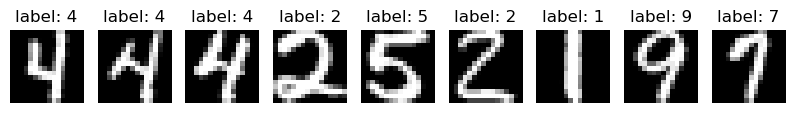

In [30]:
idx = np.random.choice(X.shape[1], size=9, replace=False)
fig, axes = plt.subplots(1,9, figsize=(10,10))
print("Extracting random data points from the dataset:")

for i, index in enumerate(idx):
    image = X[:, index].reshape(16,16)
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(f"label: {y[0, index]}")
    axes[i].axis("off")
    
for i in range(0,10,1):
    print(f"Instances of class {i}: {np.sum(y[0]==i)}")

We can clearly see that our dataset is a bit imbalanced!

• Extract from X those columns that corresponds to digits 3 or 4. Those digits represents the
classes C1 and C2 defined above.


In [41]:
C1, C2 = 3,4
idx = (y[0] == C1) | (y[0] == C2)
X_sub = X[:, idx]
y_sub = y[:, idx]
# print(X_sub.shape, y_sub.shape, y.shape)
print(f"Unique values of classes in y: {np.unique(y_sub)}")

Unique values of classes in y: [3 4]


• Split the obtained dataset in training and testing. From now on, we will only consider the training
set. The test set will be only used at the end of the exercise to test the algorithm.

In [42]:
N_train = int(0.8 * y_sub.shape[1]) # 80% of the dataset
X_train, y_train, X_test, y_test = train_test_split(X_sub, y_sub, N_train)

• Create the matrices X1 and X2 defined above from X

In [43]:
X1 = X_train[:,y_train[0] == C1]
X2 = X_train[:,y_train[0] == C2]

• Compute the SVD decomposition of X1 and X2 with `np.linalg.svd(matrix, full matrices=False)`
and denote the U-part of the two decompositions as U1 and U2

In [44]:
U1, s1, VT1 = np.linalg.svd(X1, full_matrices=False)
U2, s2, VT2 = np.linalg.svd(X2, full_matrices=False)

• Take an unknown digit y from the test set, and compute $y^⊥_1 = U_1(U^T_1y)$ and $y^⊥_2 = U_2(U^T_2y)$.  

• Compute the distances $d_1 = ||y − y^⊥_1||_2$ and $d_2 = ||y − y^⊥_2||_2$ and classify $y$:  
- to **C1** if $d1 < d2$; 
- to **C2** if $d2 < d1$.

Extracting a random datapoint from the sub-dataset. True Label: 3


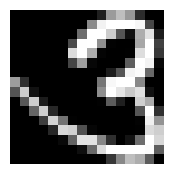

The sampled digit was classified as: 3


In [45]:
index = np.random.choice(y_test.shape[1], size = 10, replace=False)
y_true = X_test[:, index[0]] # y_true represents a datapoint!

print(f"Extracting a random datapoint from the sub-dataset. True Label: {y_test[0,index[0]]}")
plt.figure(figsize=(2,2))
plt.imshow(y_true.reshape(16,16), cmap='gray')
plt.axis('off')
plt.show()

y_1 = U1 @ (U1.T @ y_true)
y_2 = U2 @ (U2.T @ y_true)
d1 = np.linalg.norm(y_true - y_1, 2)
d2 = np.linalg.norm(y_true - y_2, 2)

if d1<=d2:
    classification = C1
else:
    classification = C2
print(f"The sampled digit was classified as: {classification}")

• Repeat the experiment for different values of y in the test set. Compute the misclassification
number for this algorithm.

In [46]:
confusion_matrix = np.zeros((2,2))
N_test = y_test.shape[1]
size = N_test
correct_classification = 0

for index in range(0,N_test):
    y_true = X_test[:, index]
    y_1 = U1 @ (U1.T @ y_true)
    y_2 = U2 @ (U2.T @ y_true)
    d1 = np.linalg.norm(y_true - y_1, 2)
    d2 = np.linalg.norm(y_true - y_2, 2)

    if d1<=d2:
        classification = C1
        if classification == y_test[0,index]:
            confusion_matrix[0,0] += 1
            correct_classification += 1
        else:
            confusion_matrix[1,0] += 1
    else:
        classification = C2
        if classification == y_test[0,index]:
            correct_classification += 1
            confusion_matrix[1,1] += 1
        else:
            confusion_matrix[0,1] += 1
print(f"CLASSES {C1} AND {C2}")            
print(f"Percentage of correct classification: {round(correct_classification/size, 2)*100}%")
print(f"\nInstances of class {C1}: {np.sum(y_test==C1)}")
print(f"Instances of class {C2}: {np.sum(y_test==C2)}")
print(f"\nConfusion matrix:\n {confusion_matrix}")

CLASSES 3 AND 4
Percentage of correct classification: 100.0%

Instances of class 3: 25
Instances of class 4: 26

Confusion matrix:
 [[25.  0.]
 [ 0. 26.]]


Classes 3 and 4 have a very close number of samples, and they look pretty different. As a matter of fact, our model had no problem in classifying them correctly! Let's see what happens with an umbalanced number of samples.  

• Repeat the experiment for different digits other than 3 or 4. There is a relationship between the
visual similarity of the digits and the classification error?

In [53]:
C1,C2,C3 = 0,5,False
test_classes(C1,C2,mnist['X'],mnist['I'],C3)


Percentage of correct classification: 74.0%

Instances of class 5: 21
Instances of class 0: 61

Confusion matrix:
 [[ 0. 21.]
 [ 0. 61.]]


We saw at the beginning that the number of instances of class 5 is way lower than the others. In fact, our model is not even able to classify a single instance of number 5! This made our model overfitted on the training data!

In [57]:
C1,C2,C3 = 4,7,False
test_classes(C1,C2,mnist['X'],mnist['I'],C3)


Percentage of correct classification: 98.0%

Instances of class 4: 27
Instances of class 7: 31

Confusion matrix:
 [[27.  0.]
 [ 1. 30.]]


even tho they look pretty similiar, our model had no problem in classifying them

2. The extension of this idea to the multiple classification task is trivial. Indeed, if we have more than 2 classes (say, k different classes) C1, . . . , Ck, we just need to repeat the same procedure as before for each matrix X1, . . . , Xk to obtain the distances d1, . . . , dk. Then, the new digit y will be classified as Ci if di is lower that dj for each j = 1, . . . , k. Repeat the exercise above with a 3-digit example. Comment the differences.

In [54]:
C1,C2,C3 = 3,8,9
test_classes(C1,C2,X,y,C3)

CLASSES 3,8,9
Percentage of correct classification: 93.0%

Instances of class 3: 27
Instances of class 8: 31
Instances of class 9: 24

Confusion matrix:
 [[23.  4.  0.]
 [ 1. 29.  1.]
 [ 0.  0. 24.]]


In [55]:
C1,C2,C3 = 1,7,9
test_classes(C1,C2,X,y,C3)

CLASSES 1,7,9
Percentage of correct classification: 75.0%

Instances of class 1: 51
Instances of class 7: 38
Instances of class 9: 21

Confusion matrix:
 [[51.  0.  0.]
 [14. 23.  1.]
 [12.  0.  9.]]
